In [1]:
import glob
import os
import sys
from pathlib import Path

import numpy as np
import torch

# 当前目录
current_dir = os.path.dirname(os.path.abspath("__file__"))
# 上一级目录
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)
# 上两级目录
grandparent_dir = os.path.abspath(os.path.join(parent_dir, ".."))
sys.path.append(grandparent_dir)

# 上两级目录
grandgrandparent_dir = os.path.abspath(os.path.join(grandparent_dir, ".."))
sys.path.append(grandgrandparent_dir)

from config_plot import *
from data import get_data
from network import PINN
from utils import (
    Logger,
    count_parameters,
    from_pickle,
    load_network,
    read_config_file,
    set_random_seed,
    tensors_to_numpy,
    to_pickle,
)

In [2]:
import scipy.io

# config

In [3]:
######################################################################
#
# env config
#
######################################################################
# Env
set_random_seed(random_seed=0)
os.makedirs(output_dir, exist_ok=True)

# Logger
logger = Logger(output_dir)

# Config
config_file_path = "/home/lbu/project/pinn_vibration/ex_burgers/config.py"
config = read_config_file(config_file_path)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# 空间和时间网格的大小和步长
M = 100  # 空间网格点数
N = 256  # 时间步数
L = 1.0  # 空间范围[-1, 1]
T = 1.0  # 时间范围[0, 1]
dx = L / M
dt = T / N

# 初始化网格和初始条件
x = np.linspace(-1, 1, M + 1)
t = np.linspace(0, 1, N + 1)
u = np.zeros((N + 1, M + 1))

# 设置初始条件
u[0, :] = -np.sin(np.pi * x)

# 时间步进迭代
for n in range(N):
    for i in range(1, M):
        u_x = (u[n, i + 1] - u[n, i - 1]) / (2 * dx)
        term1 = u[n, i] * u_x
        u_xx = (u[n, i + 1] - 2 * u[n, i] + u[n, i - 1]) / dx**2
        term2 = 0.01 * u_xx / np.pi
        u[n + 1, i] = u[n, i] + dt * (-term1 + term2)

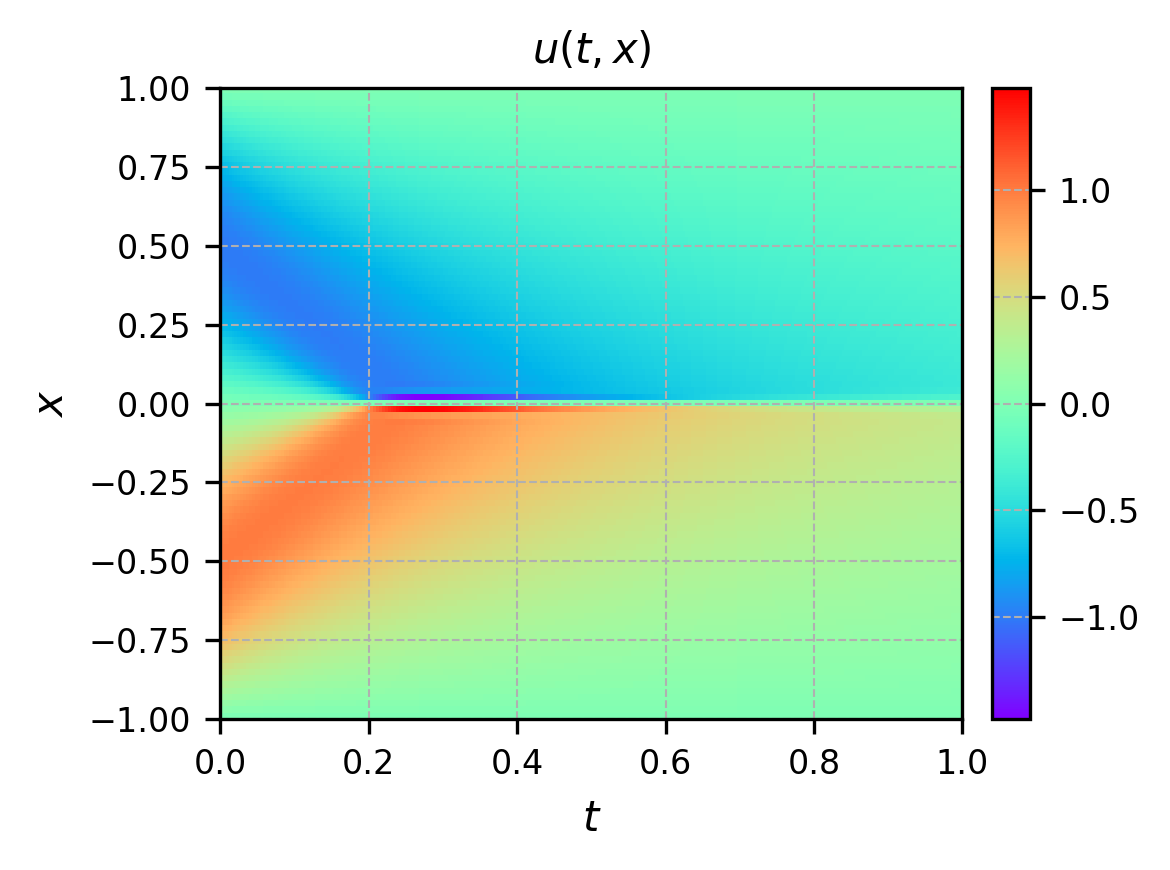

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(4 * 1, 3 * 1), dpi=Latex_DPI)
subfig = axs
subfig.set_title("$u(t,x)$")
subfig.set_xlabel("$t$")
subfig.set_ylabel("$x$")
h = subfig.imshow(
    u.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(subfig)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
subfig.tick_params()

plt.tight_layout()

path = os.path.join(output_dir, "GT.png")
plt.savefig(path)

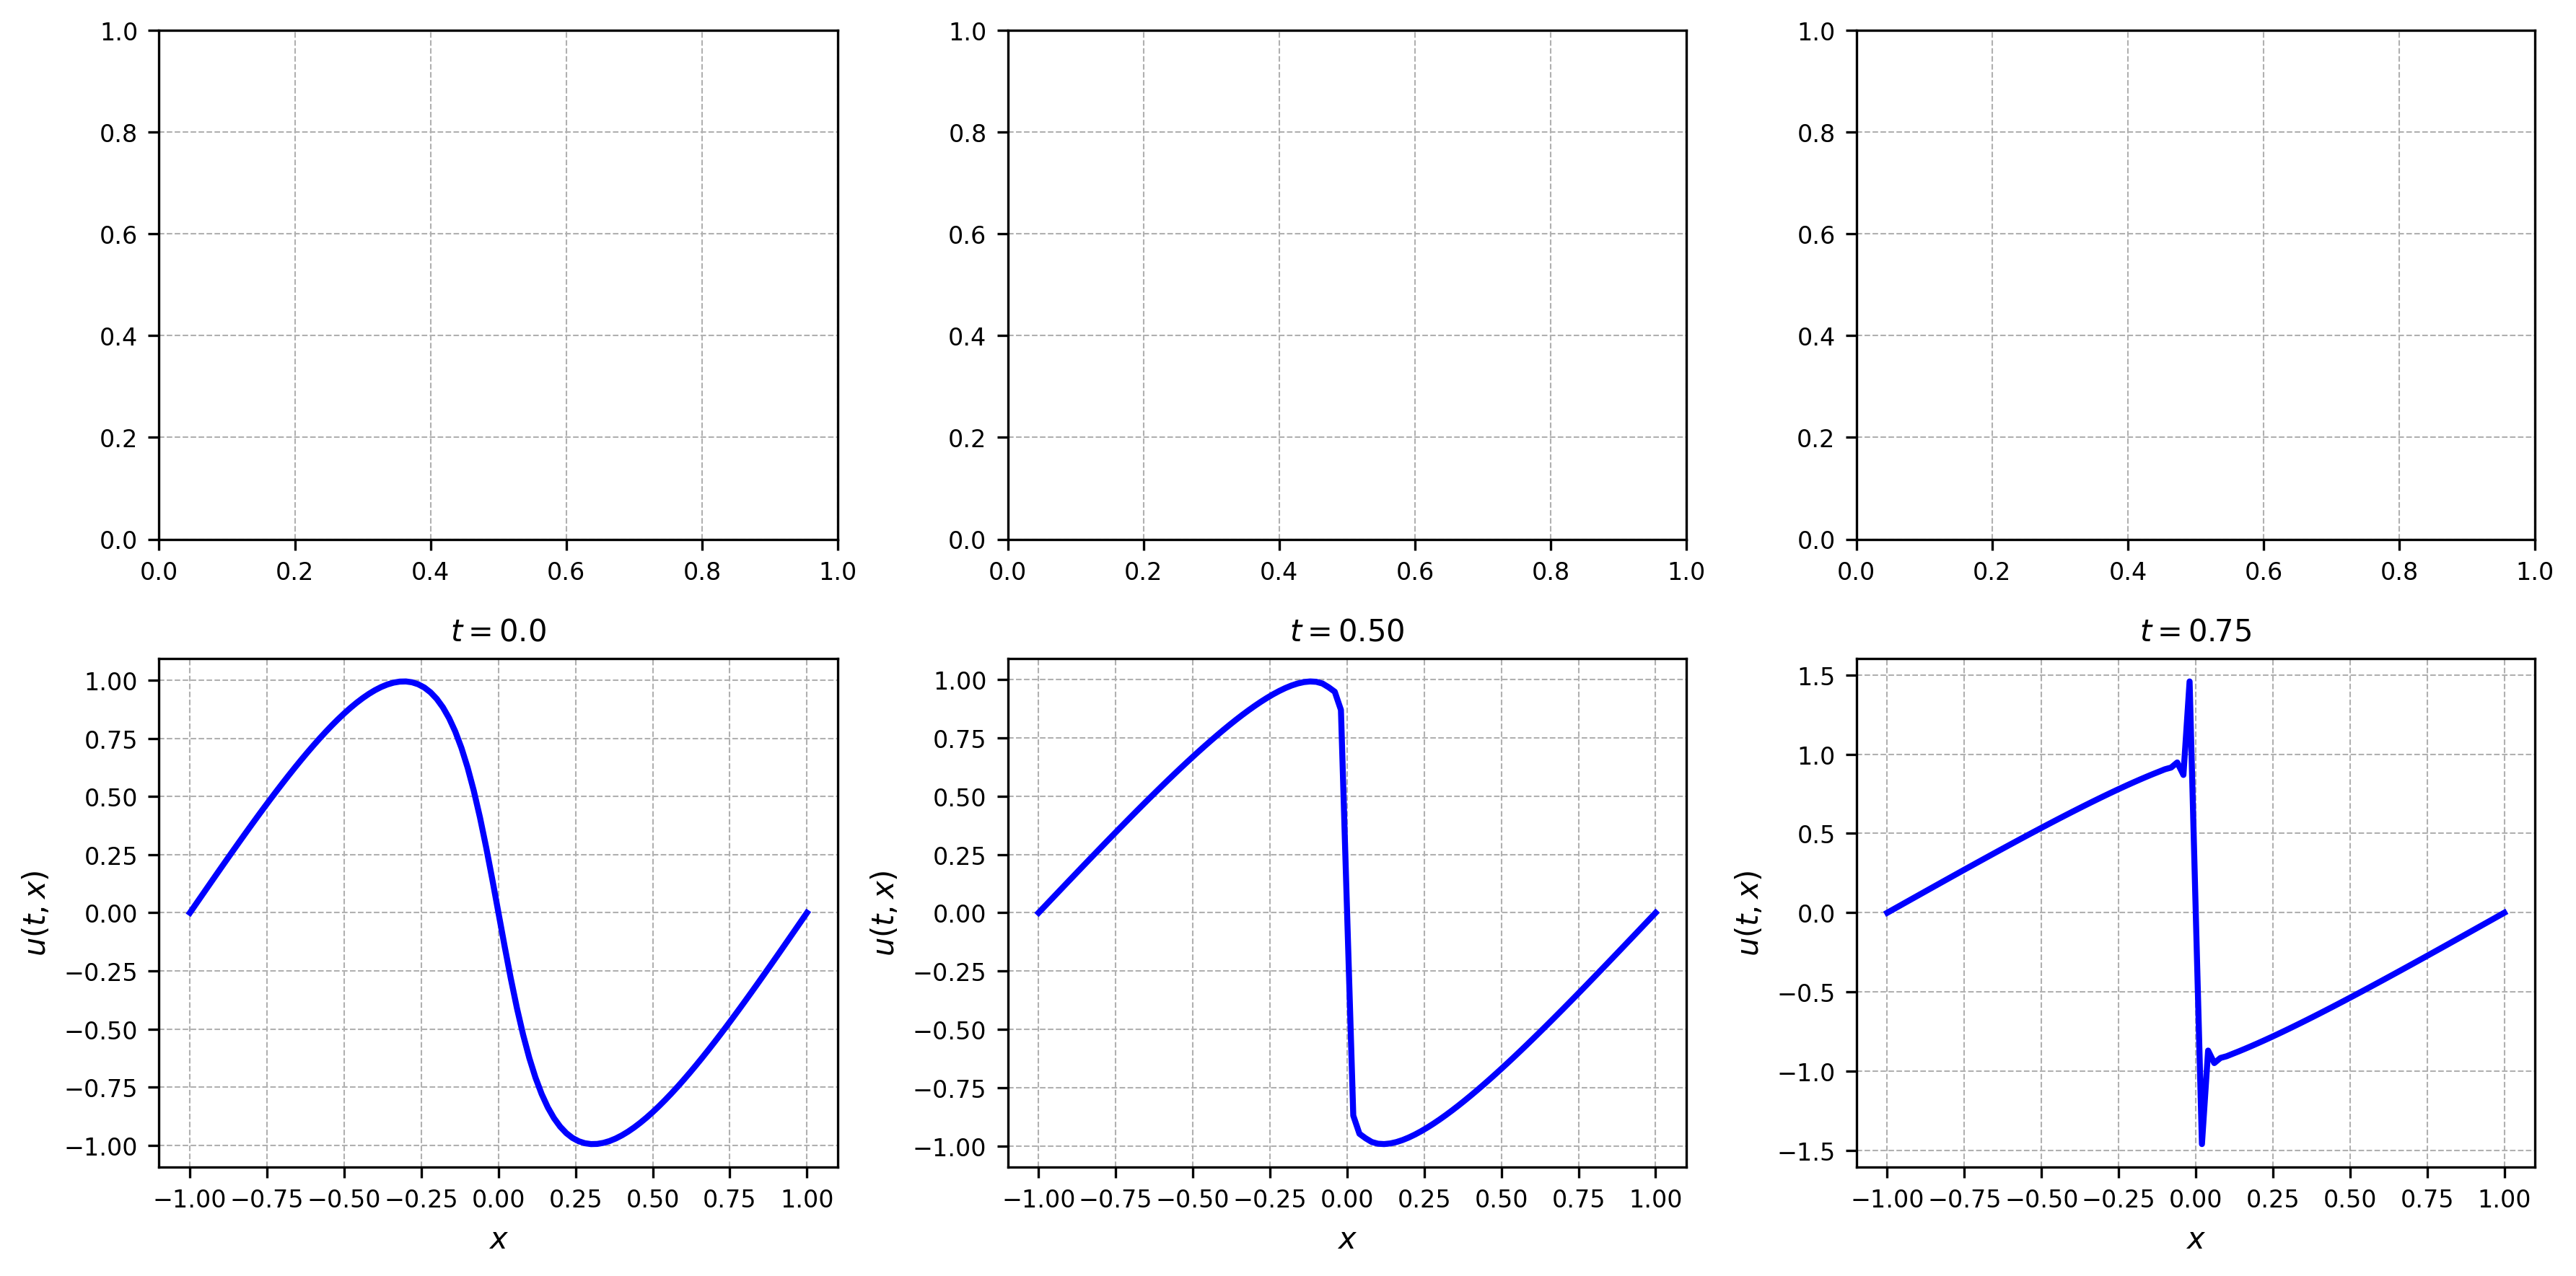

In [12]:
# plot
fig, axs = plt.subplots(2, 3, figsize=(4 * 3, 3 * 2), dpi=Latex_DPI)

subfig = axs[1, 0]
subfig.set_title("$t=0.0$")
subfig.set_xlabel("$x$")
subfig.set_ylabel("$u(t,x)$")
subfig.plot(x, u[25, :], "b-", linewidth=2, label="Exact")

subfig = axs[1, 1]
subfig.set_title("$t=0.50$")
subfig.set_xlabel("$x$")
subfig.set_ylabel("$u(t,x)$")
subfig.plot(x, u[50, :], "b-", linewidth=2, label="Exact")

subfig = axs[1, 2]
subfig.set_title("$t=0.75$")
subfig.set_xlabel("$x$")
subfig.set_ylabel("$u(t,x)$")
subfig.plot(x, u[75, :], "b-", linewidth=2, label="Exact")

plt.tight_layout()

path = os.path.join(output_dir, "PINN_Burgers_result.png")
plt.savefig(path)